# Smoking Status Detection

Key contents:


*   Data Cleaning: Sentence tokenization, sentence selection based on regex pattern, word tokenization, removal of punctuation, stop words and dates/numbers (for now. We should probably include numbers)
*   Data Preprocessing: TFIDF from scikit learn to create vectors of bigrams, unigrams and trigrams currently
*   Data Train Test split: Using test_set_labeled and train_set for this example. Used the same vectorizor on both sets
*   Tried to fit Multiclass Logistic Regression Model that gave pretty bad results
*   Checked metrics and confusion matrix



# Importing Training Data and Preprocessing


In [ ]:
from collections import Counter
import nltk
import pandas as pd
import numpy as np
import collections, numpy
#import mlxtend
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
matplotlib.rcParams['figure.figsize'] = (10, 10)


from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
#from mlxtend.plotting import plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from nltk.tokenize import sent_tokenize
import pandas as pd
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
import xml.etree.ElementTree as ET


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/Georgetown/Massv_Health_Data_Fund/Final_Project/smoking_status_train.xml"
test_path = "/content/drive/MyDrive/Georgetown/Massv_Health_Data_Fund/Final_Project/smoking_status_test.xml"
test_path_labeled = "/content/drive/MyDrive/Georgetown/Massv_Health_Data_Fund/Final_Project/smoking_status_test_with_labels.xml"

def read_xml_custom(file_path, df_name):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract records into a list of dictionaries
    records = []
    for record in root.findall('RECORD'):
        record_id = record.get('ID')
        smoking_status = record.find('SMOKING').get('STATUS') if record.find('SMOKING') is not None else None
        text_content = record.find('TEXT').text.replace('\n', ' ').strip() if record.find('TEXT') is not None else None

        records.append({'ID': record_id, 'SMOKING': smoking_status, 'TEXT': text_content})

    # Create and return a DataFrame
    return pd.DataFrame(records)

# Example usage
train_set = read_xml_custom(train_path, 'train_set')

train_set.head()

,ID,SMOKING,TEXT
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))

# Function to process text
import string
string.punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Some Helper Functions for Preprocessing

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Minimal Working Example of Negation Detection

In [ ]:
import spacy

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

def tokenize_with_negations(text):
    doc = nlp(text)
    negated_tokens = []
    other_tokens = []

    for token in doc:
        if token.dep_ == "neg":  # Token has a "neg" (negation) dependency
            negated_tokens.append(f"NOT_{token.head.text.lower()}")  # Add "not" to the head of the token
        else:
            # Otherwise, just add the token text itself
            other_tokens.append(token.text.lower())

    final_tokens = negated_tokens + other_tokens

    return final_tokens

# Test sentence
text = "The patient does not smoke."
negations = tokenize_with_negations(text)
print("Negations detected:", negations)


Negations detected: ['NOT_smoke', 'the', 'patient', 'does', 'smoke', '.']


In [ ]:

import string
import re
import nltk
from nltk.util import ngrams

# Stop words (example, you should use a more comprehensive list)
stop_words = set(nltk.corpus.stopwords.words("english"))


def generate_trigrams(tokens):
    """Generate trigrams from token list."""
    return ['_'.join(trigram) for trigram in ngrams(tokens, 3)]

def generate_bigrams(tokens):
    """Generate bigrams from token list."""
    return ['_'.join(bigram) for bigram in ngrams(tokens, 2)]

def process_text(text):
    # If input is a list, join into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Tokenize text using negex to handle negations
    words = tokenize_with_negations(text)

    # Step 1: Remove punctuations and convert to lowercase
    words_no_punc = [word.lower() for word in words if word not in string.punctuation]

    # Step 2: Remove stopwords
    clean_words = [word for word in words_no_punc if word not in stop_words]

    # Step 3: Remove numbers and dates (any word with digits)
    final_words = [word for word in clean_words if not re.search(r'\d', word)]

    return final_words


def select_smoking_sentences(text, pattern):
    # Tokenize text into sentences
    sentences = nltk.sent_tokenize(text)

    # Select sentences matching the smoking pattern
    smoking_sentences = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]

    return smoking_sentences


### Smoking Related Sentence Selection

In [ ]:
# Apply to each row in the DataFrame
smoking_patt = r'\b(smok[a-z]*|cig[a-z]*|cigarette[s]?|ciggie[s]?|cigar[s]?|cigs?|carton[s]?|pipes?|packs?|tobaccos?|nicotine|vape|e-cigarette[s]?|chewing\s+tobacco|snuff|hookah)\b' #reg exp for smoking related terms to pattern match sentences after tokenizing

train_set['SENTENCE_SMOKING'] = train_set['TEXT'].apply(lambda x: select_smoking_sentences(x, smoking_patt))
train_set.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,"[Drinks ginger brandy to excess , pipe and cig..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[HABITS : The patient has a 20 pack-year smoki...
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[SOCIAL HISTORY : Smoker for greater than 100 ...
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[1-2 packs per day .]


In [ ]:
train_set['SENTENCE_SMOKING'][0]

['Drinks ginger brandy to excess , pipe and cigar smoker for many years .']

In [ ]:
# Check for nulls in sentence_smoking field

#train_set['SENTENCE_SMOKING'].isnull().sum()
train_set['SENTENCE_SMOKING'][393]

[]

### Cleaning Those Sentences and Creating Tokens, Bigrams and Trigrams

In [ ]:
# Now clean those sentences and create word tokens

train_set['CLEANED_TOKENS'] = train_set['SENTENCE_SMOKING'].apply(process_text)
train_set.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,"[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack, year, smoking, history]"
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]"
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[1-2 packs per day .],"[packs, per, day]"


In [ ]:
print(train_set['CLEANED_TOKENS'].head())


0    [drinks, ginger, brandy, excess, pipe, cigar, ...
1      [habits, patient, pack, year, smoking, history]
2            [smoking, approximately, cigarettes, day]
3    [social, history, smoker, greater, pack, years...
4                                    [packs, per, day]
Name: CLEANED_TOKENS, dtype: object


In [ ]:
train_set['CLEANED_TOKENS'][0]

['drinks',
 'ginger',
 'brandy',
 'excess',
 'pipe',
 'cigar',
 'smoker',
 'many',
 'years']

In [ ]:
# Verify the negation is working
negation_rows = train_set[train_set['CLEANED_TOKENS'].apply(lambda tokens: any(token.startswith('not_') for token in tokens))]

# Display the rows where negations are found
print(negation_rows)


      ID         SMOKING                                               TEXT  \
12   564  CURRENT SMOKER  559197012 FIH 4469096 64024/p16e 909222 10/24/...   
21   718      NON-SMOKER  988183518 PUOMC 7961198 290757 137082 1/25/199...   
22   742      NON-SMOKER  701572223 PUOMC 5669108 996091 857234 11/26/19...   
24   761      NON-SMOKER  977159532 CTMC 66232708 800550 4/26/1990 12:00...   
26   766      NON-SMOKER  262912613 CTMC 43279523 551881 6/25/1990 12:00...   
29   799      NON-SMOKER  857888116 CTMC 36320247 6680133 New Years Day ...   
30   823      NON-SMOKER  867290496 CTMC 50889296 765801 4/2/1991 12:00:...   
31   839      NON-SMOKER  378274921 PUOMC 0641514 28078/70a4 712822 5/1/...   
34   868      NON-SMOKER  812367409 SH 21952193 06/19/1991 12:00:00 AM D...   
39   907      NON-SMOKER  139391631 GH 97368061 7/20/1999 12:00:00 AM NE...   
41   519      NON-SMOKER  846470157 FIH 2831385 45917/em77 071794 5/13/1...   
43   542      NON-SMOKER  407060601 FIH 9835577 7426

In [ ]:
train_set['BIGRAMS'] = train_set['CLEANED_TOKENS'].apply(generate_bigrams)
train_set.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,BIGRAMS
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,"[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ...","[drinks_ginger, ginger_brandy, brandy_excess, ..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack, year, smoking, history]","[habits_patient, patient_pack, pack_year, year..."
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]","[smoking_approximately, approximately_cigarett..."
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years...","[social_history, history_smoker, smoker_greate..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[1-2 packs per day .],"[packs, per, day]","[packs_per, per_day]"


In [ ]:
train_set['TRIGRAMS'] = train_set['CLEANED_TOKENS'].apply(generate_trigrams)
train_set.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,BIGRAMS,TRIGRAMS
0,641,CURRENT SMOKER,977146916 HLGMC 2878891 022690 01/27/1997 12:0...,"[Drinks ginger brandy to excess , pipe and cig...","[drinks, ginger, brandy, excess, pipe, cigar, ...","[drinks_ginger, ginger_brandy, brandy_excess, ...","[drinks_ginger_brandy, ginger_brandy_excess, b..."
1,643,CURRENT SMOKER,026738007 CMC 15319689 3/25/1998 12:00:00 AM M...,[HABITS : The patient has a 20 pack-year smoki...,"[habits, patient, pack, year, smoking, history]","[habits_patient, patient_pack, pack_year, year...","[habits_patient_pack, patient_pack_year, pack_..."
2,681,CURRENT SMOKER,071962960 BH 4236518 417454 12/10/2001 12:00:0...,[HAS BEEN SMOKING APPROXIMATELY 10 CIGARETTES ...,"[smoking, approximately, cigarettes, day]","[smoking_approximately, approximately_cigarett...","[smoking_approximately_cigarettes, approximate..."
3,704,CURRENT SMOKER,418520250 NVH 61562872 3/11/1995 12:00:00 AM D...,[SOCIAL HISTORY : Smoker for greater than 100 ...,"[social, history, smoker, greater, pack, years...","[social_history, history_smoker, smoker_greate...","[social_history_smoker, history_smoker_greater..."
4,757,CURRENT SMOKER,301443520 CTMC 49020928 448922 1/11/1990 12:00...,[1-2 packs per day .],"[packs, per, day]","[packs_per, per_day]",[packs_per_day]


# Importing and Preparing Test Set


In [ ]:
test_set_labeled = read_xml_custom(test_path_labeled, 'test_set')
test_set_labeled.head()

,ID,SMOKING,TEXT
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...


In [ ]:
test_set_labeled['SENTENCE_SMOKING'] = test_set_labeled['TEXT'].apply(lambda x: select_smoking_sentences(x, smoking_patt))
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...


In [ ]:
test_set_labeled['SENTENCE_SMOKING'].isnull().sum()

0

In [ ]:
test_set_labeled['CLEANED_TOKENS'] = test_set_labeled['SENTENCE_SMOKING'].apply(process_text)
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]"
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ..."
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d, social, history, ..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]"


In [ ]:
test_set_labeled['BIGRAMS'] = test_set_labeled['CLEANED_TOKENS'].apply(generate_bigrams)
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,BIGRAMS
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]","[heavy_smoker, smoker_drinks, drinks_shots, sh..."
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy...","[history_tobacco, tobacco_use, use_tobacco, to..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ...","[cut_dramatically, dramatically_smoking, smoki..."
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d, social, history, ...","[questran_one, one_pack, pack_q.i.d, q.i.d_soc..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]","[smoker_presented, presented_day, day_admissio..."


In [ ]:
test_set_labeled['TRIGRAMS'] = test_set_labeled['CLEANED_TOKENS'].apply(generate_trigrams)
test_set_labeled.head()

,ID,SMOKING,TEXT,SENTENCE_SMOKING,CLEANED_TOKENS,BIGRAMS,TRIGRAMS
0,660,PAST SMOKER,156406283 HLGMC 7213645 64723/51cy 5/28/1993 1...,[He is a heavy smoker and drinks 2-3 shots per...,"[heavy, smoker, drinks, shots, per, day, times]","[heavy_smoker, smoker_drinks, drinks_shots, sh...","[heavy_smoker_drinks, smoker_drinks_shots, dri..."
1,845,CURRENT SMOKER,487197293 PUOMC 2466262 408602 1976045 4/26/20...,"[History of tobacco use ., TOBACCO : Former he...","[history, tobacco, use, tobacco, former, heavy...","[history_tobacco, tobacco_use, use_tobacco, to...","[history_tobacco_use, tobacco_use_tobacco, use..."
2,515,CURRENT SMOKER,176318078 FIH 4189699 28872/d70h 094756 11/03/...,[She cut down dramatically on smoking two year...,"[cut, dramatically, smoking, two, years, ago, ...","[cut_dramatically, dramatically_smoking, smoki...","[cut_dramatically_smoking, dramatically_smokin..."
3,562,CURRENT SMOKER,245096078 FIH 9174858 12/February 997359 11/3/...,"[, Questran one pack q.i.d., SOCIAL HISTORY : ...","[questran, one, pack, q.i.d, social, history, ...","[questran_one, one_pack, pack_q.i.d, q.i.d_soc...","[questran_one_pack, one_pack_q.i.d, pack_q.i.d..."
4,633,CURRENT SMOKER,237073320 FIH 9746390 797120 251605 01/26/1998...,[She has been a smoker and presented on the da...,"[smoker, presented, day, admission, dizziness]","[smoker_presented, presented_day, day_admissio...","[smoker_presented_day, presented_day_admission..."


# Vectorize the test and train tokens into TF-IDF Vectors


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=None, use_idf=True) #using unigrams, bigrams and trigrams in my vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Define separate n-gram ranges for unigrams, bigrams, and trigrams
vectorizer_unigrams = TfidfVectorizer(ngram_range=(1, 1))
vectorizer_bigrams = TfidfVectorizer(ngram_range=(2, 2))
vectorizer_trigrams = TfidfVectorizer(ngram_range=(3, 3))

# Fit and transform the text data using each vectorizer
X_unigrams = vectorizer_unigrams.fit_transform(train_set['CLEANED_TOKENS'].apply(lambda x: ' '.join(x)))
X_bigrams = vectorizer_bigrams.fit_transform(train_set['BIGRAMS'].apply(lambda x: ' '.join(x)))
X_trigrams = vectorizer_trigrams.fit_transform(train_set['TRIGRAMS'].apply(lambda x: ' '.join(x)))

X_unigrams_test = vectorizer_unigrams.transform(test_set_labeled['CLEANED_TOKENS'].apply(lambda x: ' '.join(x)))
X_bigrams_test = vectorizer_bigrams.transform(test_set_labeled['BIGRAMS'].apply(lambda x: ' '.join(x)))
X_trigrams_test = vectorizer_trigrams.transform(test_set_labeled['TRIGRAMS'].apply(lambda x: ' '.join(x)))

# Combine the features into a single feature matrix
from scipy.sparse import hstack
X_combined = hstack([X_unigrams, X_bigrams, X_trigrams])

X_combined_test = hstack([X_unigrams_test, X_bigrams_test, X_trigrams_test])

print(X_combined.shape, X_combined_test.shape)

(398, 4650) (104, 4650)


Generating Word Clouds

In [ ]:
!pip install wordcloud

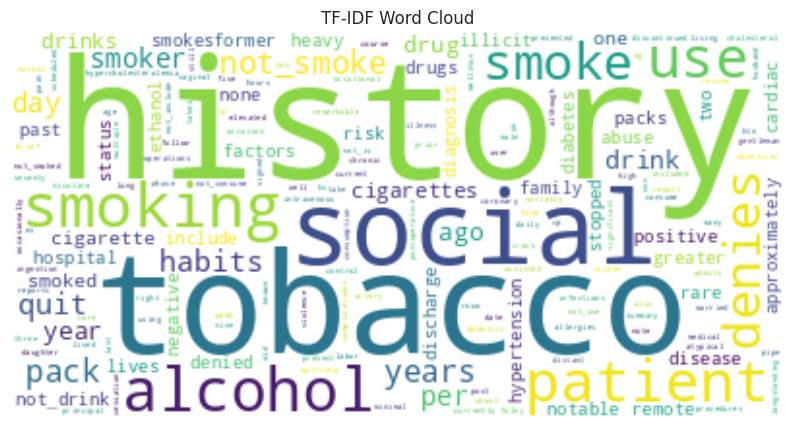

In [ ]:
train_tfidf_df = pd.DataFrame(X_unigrams.toarray(), columns=vectorizer_unigrams.get_feature_names_out())


from wordcloud import WordCloud

# Get average TF-IDF scores for each term
avg_tfidf = train_tfidf_df.mean(axis=0)

# Create a word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(avg_tfidf)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud")
plt.show()


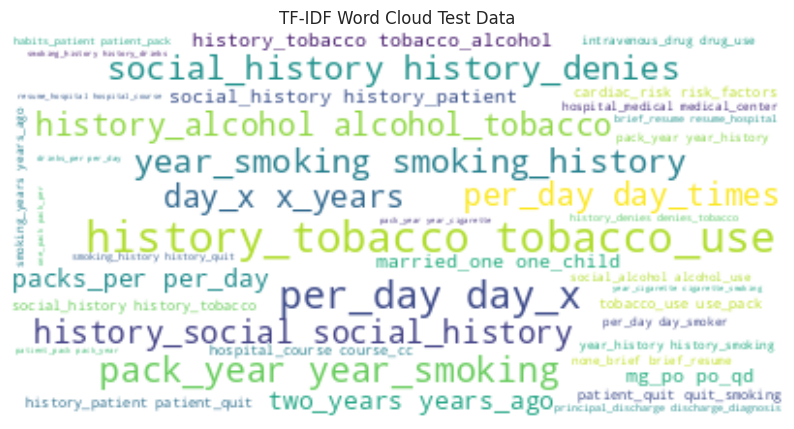

In [ ]:
test_tfidf_df = pd.DataFrame(X_bigrams_test.toarray(), columns=vectorizer_bigrams.get_feature_names_out())

from wordcloud import WordCloud

# Get average TF-IDF scores for each term
avg_tfidf_test = test_tfidf_df.mean(axis=0)

# Create a word cloud
wordcloud_test = WordCloud(background_color="white").generate_from_frequencies(avg_tfidf_test)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_test, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud Test Data")
plt.show()

# Model Training and Testing
### Multi Class Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train = X_combined
y_train = train_set['SMOKING']
X_test = X_combined_test
y_test = test_set_labeled['SMOKING']

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (398, 4650)
Shape of X_test: (104, 4650)


In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.50      0.27      0.35        11
    NON-SMOKER       0.82      0.56      0.67        16
   PAST SMOKER       0.75      0.27      0.40        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.76      1.00      0.86        63

      accuracy                           0.75       104
     macro avg       0.57      0.42      0.46       104
  weighted avg       0.72      0.75      0.70       104



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model Performance

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Print classification report (precision, recall, F1-score for each class)
print(classification_report(y_test, y_pred))

# Calculate and print overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


                precision    recall  f1-score   support

CURRENT SMOKER       0.50      0.27      0.35        11
    NON-SMOKER       0.82      0.56      0.67        16
   PAST SMOKER       0.75      0.27      0.40        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.76      1.00      0.86        63

      accuracy                           0.75       104
     macro avg       0.57      0.42      0.46       104
  weighted avg       0.72      0.75      0.70       104

Accuracy: 0.75
Confusion Matrix:
[[ 3  1  1  0  6]
 [ 0  9  0  0  7]
 [ 2  1  3  0  5]
 [ 1  0  0  0  2]
 [ 0  0  0  0 63]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


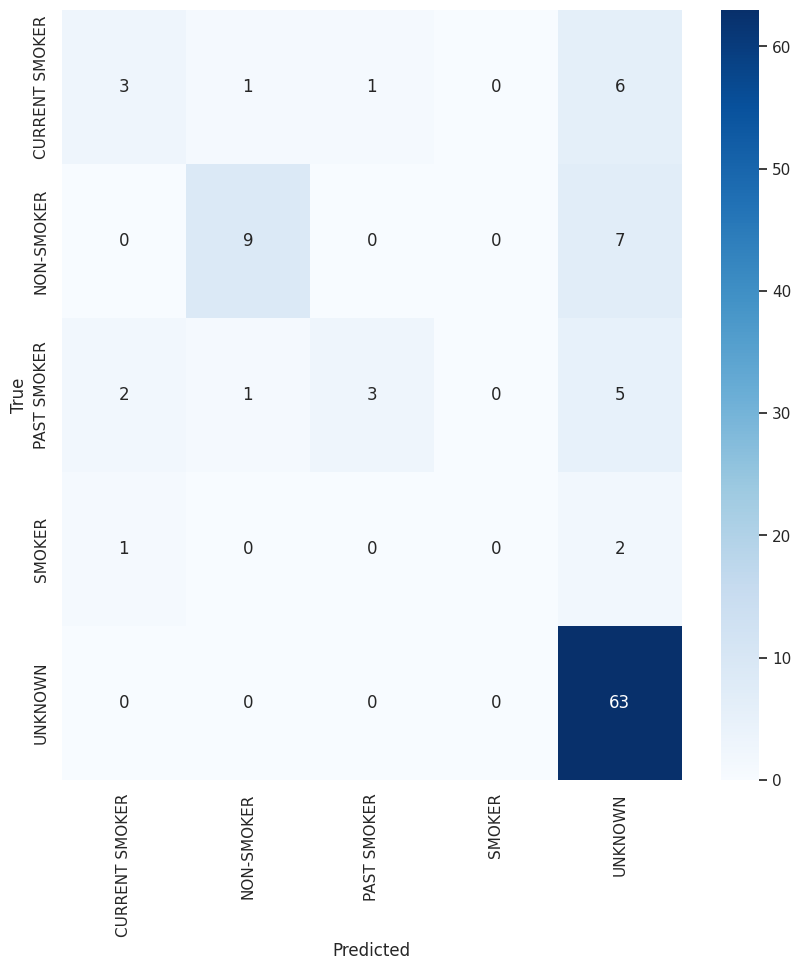

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Displaying Top Features per Class

Unigrams

In [ ]:
feature_names = vectorizer_unigrams.get_feature_names_out()
important_features = model.coef_

# Print top features for each class
for i, class_name in enumerate(["past smoker", "current smoker", "non smoker", "unknown", "smoker"]):
    top_features = sorted(zip(important_features[i], feature_names), reverse=True)[:10]
    print(f"Top features for {class_name}: by Unigrams Vectorizer")
    for score, feature in top_features:
        print(f"{feature}: {score}")

Top features for past smoker: by Unigrams Vectorizer
day: 1.2574955129477798
pack: 0.9215523945103693
per: 0.8692773895741074
smoking: 0.8254175605766851
year: 0.7932599799705097
packs: 0.6853160286423872
smokes: 0.5215424659643114
patient: 0.49794813617540346
approximately: 0.49100556363805986
smoker: 0.4887528284369416
Top features for current smoker: by Unigrams Vectorizer
tobacco: 2.030493946690956
smoke: 1.7115573169777432
not_smoke: 1.6533384348171385
alcohol: 1.6218661595539818
denies: 1.3846320145339497
use: 0.9687539061107842
social: 0.8935265905590014
drink: 0.8680198896645976
history: 0.8318146652055374
habits: 0.6791081224484111
Top features for non smoker: by Unigrams Vectorizer
quit: 2.0536623314717035
years: 1.322709171465466
ago: 1.2567559797086723
smoked: 0.8718309142268168
remote: 0.8202923998361286
smoker: 0.7660702801790666
former: 0.7026334305302027
history: 0.6751367283470324
past: 0.6482436553558192
social: 0.5786654911625364
Top features for unknown: by Unigrams

Bigrams

In [ ]:
feature_names = vectorizer_bigrams.get_feature_names_out()
important_features = model.coef_

# Print top features for each class
for i, class_name in enumerate(["past smoker", "current smoker", "non smoker", "unknown", "smoker"]):
    top_features = sorted(zip(important_features[i], feature_names), reverse=True)[:10]
    print(f"Top features for {class_name}: by Bigrams Vectorizer")
    for score, feature in top_features:
        print(f"{feature}: {score}")

Top features for past smoker: by Bigrams Vectorizer
call_help help_quitting: 1.2574955129477798
fh_htn htn_tobacco: 0.9215523945103693
follow_pleural pleural_effusions: 0.8692773895741074
history_smoker smoker_last: 0.8254175605766851
known_allergies allergies_admit: 0.7932599799705097
fh_none none_known: 0.6853160286423872
history_smoke smoke_tobacco: 0.5215424659643114
follow_appointment appointment_firmert: 0.49794813617540346
admission_date date_report: 0.49100556363805986
history_significant significant_lung: 0.4887528284369416
Top features for current smoker: by Bigrams Vectorizer
hypercholesterolemia_h h_bell: 2.030493946690956
history_remote remote_smoking: 1.7115573169777432
exercise_stress stress_test: 1.6533384348171385
abnormal_papanicolaou papanicolaou_smear: 1.6218661595539818
cardiac_risk risk_factors: 1.3846320145339497
include_positive positive_family: 0.9687539061107842
history_smoking smoking_alcohol: 0.8935265905590014
chest_pain pain_arm: 0.8680198896645976
date_re

Trigrams

In [ ]:
feature_names = vectorizer_trigrams.get_feature_names_out()
important_features = model.coef_

# Print top features for each class
for i, class_name in enumerate(["past smoker", "current smoker", "non smoker", "unknown", "smoker"]):
    top_features = sorted(zip(important_features[i], feature_names), reverse=True)[:10]
    print(f"Top features for {class_name}: by Trigrams Vectorizer")
    for score, feature in top_features:
        print(f"{feature}: {score}")

Top features for past smoker: by Trigrams Vectorizer
brief_resume_hospital resume_hospital_course hospital_course_yo: 1.2574955129477798
fibroids_p_breast p_breast_abscess breast_abscess_htn: 0.9215523945103693
formerly_pack_per pack_per_day per_day_long: 0.8692773895741074
history_stopped_smoking stopped_smoking_years smoking_years_ago: 0.8254175605766851
labor_physical_examination physical_examination_height examination_height_hospital: 0.7932599799705097
fibroids_vein_stripping vein_stripping_meds stripping_meds_lipitor: 0.6853160286423872
history_social_history social_history_habits history_habits_include: 0.5215424659643114
food_latex_allergies latex_allergies_social allergies_social_history: 0.49794813617540346
abuse_sinus_bradycardia sinus_bradycardia_operations bradycardia_operations_procedures: 0.49100556363805986
history_smoking_quit smoking_quit_ten quit_ten_years: 0.4887528284369416
Top features for current smoker: by Trigrams Vectorizer
hypertension_diabetes_mellitus diabe

### MultiClass SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Initialize the SVM model
model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)  # 'linear' kernel is commonly used for text classification, One Vs Rest strategy "OVR"


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

CURRENT SMOKER       0.30      0.27      0.29        11
    NON-SMOKER       0.80      0.75      0.77        16
   PAST SMOKER       0.80      0.36      0.50        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.85      1.00      0.92        63

      accuracy                           0.79       104
     macro avg       0.55      0.48      0.50       104
  weighted avg       0.76      0.79      0.76       104



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[ 3  2  1  0  5]
 [ 0 12  0  0  4]
 [ 5  1  4  0  1]
 [ 2  0  0  0  1]
 [ 0  0  0  0 63]]


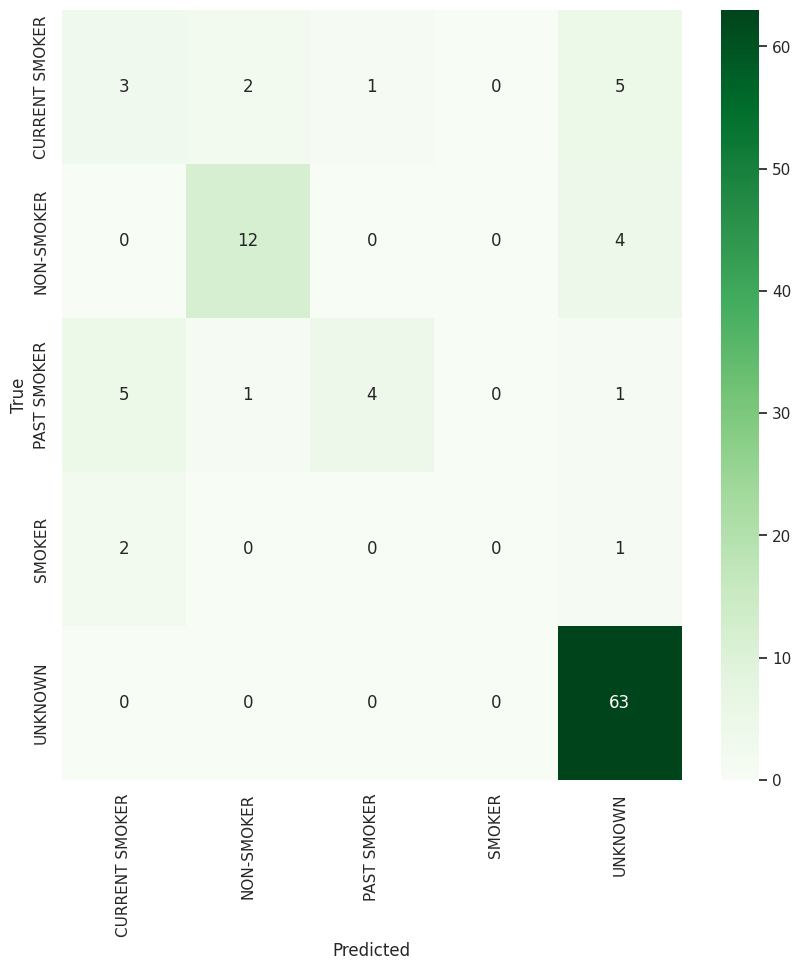

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_svm)

sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Greens", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MultiClass SVM with Scaling

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.43      0.27      0.33        11
    NON-SMOKER       0.86      0.38      0.52        16
   PAST SMOKER       1.00      0.18      0.31        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.72      1.00      0.83        63

      accuracy                           0.71       104
     macro avg       0.60      0.37      0.40       104
  weighted avg       0.72      0.71      0.65       104

Confusion Matrix:
[[ 3  1  0  0  7]
 [ 0  6  0  0 10]
 [ 3  0  2  0  6]
 [ 1  0  0  0  2]
 [ 0  0  0  0 63]]


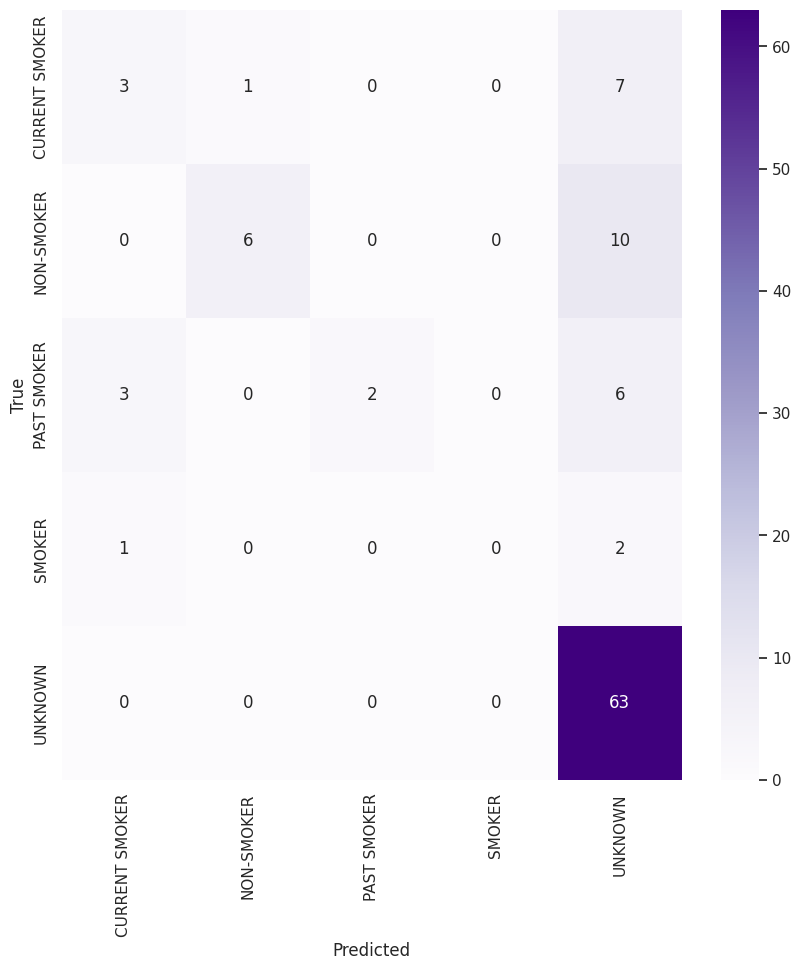

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.toarray())  # toarray() converts sparse matrix to dense
# Transform the test data using the same scaler (we don't fit it again)
X_test_scaled = scaler.transform(X_test.toarray())

# Initialize the SVM model
model = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))

conf_matrix_svm_scaled = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_svm_scaled)

sns.heatmap(conf_matrix_svm_scaled, annot=True, fmt="d", cmap="Purples", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Naive-Bayes

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.00      0.00      0.00        11
    NON-SMOKER       0.81      0.81      0.81        16
   PAST SMOKER       0.75      0.27      0.40        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.75      1.00      0.86        63

      accuracy                           0.76       104
     macro avg       0.46      0.42      0.41       104
  weighted avg       0.66      0.76      0.69       104

Confusion Matrix:
[[ 0  2  1  0  8]
 [ 0 13  0  0  3]
 [ 0  1  3  0  7]
 [ 0  0  0  0  3]
 [ 0  0  0  0 63]]


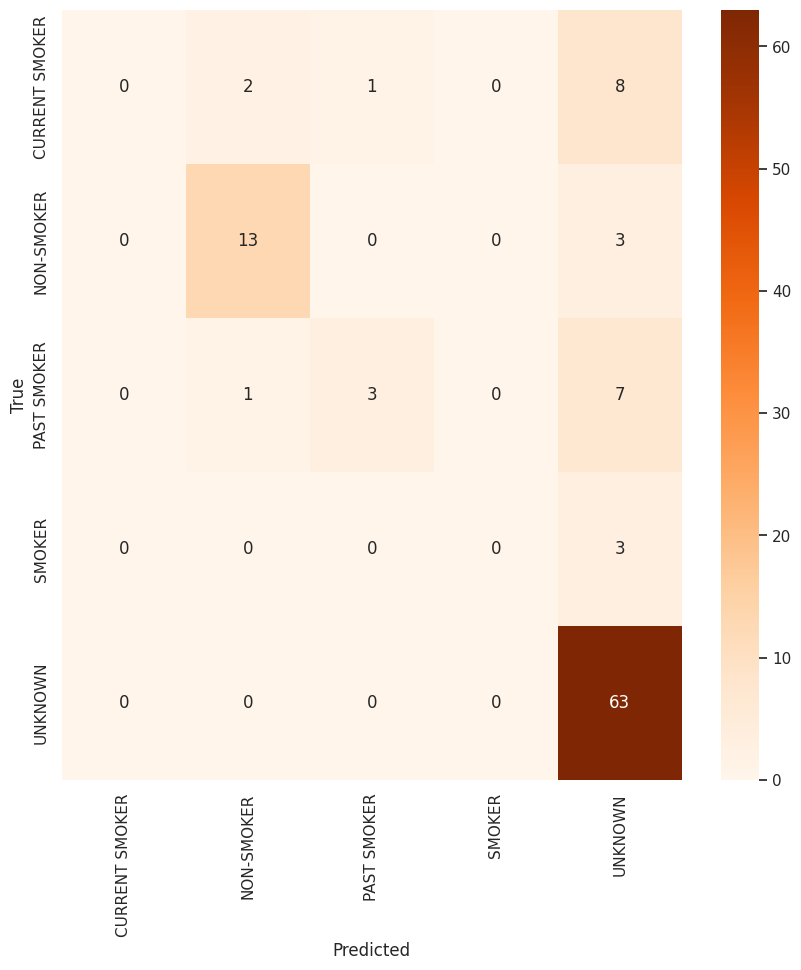

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Convert the list of tokens in SENTENCE_SMOKING to a single string
train_set['STR_SMOKING'] = train_set['SENTENCE_SMOKING'].apply(lambda x: ' '.join(x))
test_set_labeled['STR_SMOKING'] = test_set_labeled['SENTENCE_SMOKING'].apply(lambda x: ' '.join(x))

# Create a pipeline that first vectorizes the text using TF-IDF, then applies Naive Bayes
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), stop_words='english'), MultinomialNB())

# Fit the model with training data
model.fit(train_set['STR_SMOKING'], train_set['SMOKING'])

# Predict on the test set
y_pred = model.predict(test_set_labeled['STR_SMOKING'])

# Print the classification report to evaluate performance
print(classification_report(test_set_labeled['SMOKING'], y_pred))

conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_nb)

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Oranges", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Naive-Bayes on other features


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

CURRENT SMOKER       0.00      0.00      0.00        11
    NON-SMOKER       0.81      0.81      0.81        16
   PAST SMOKER       0.80      0.36      0.50        11
        SMOKER       0.00      0.00      0.00         3
       UNKNOWN       0.76      1.00      0.86        63

      accuracy                           0.77       104
     macro avg       0.47      0.44      0.44       104
  weighted avg       0.67      0.77      0.70       104

Confusion Matrix:
[[ 0  2  1  0  8]
 [ 0 13  0  0  3]
 [ 0  1  4  0  6]
 [ 0  0  0  0  3]
 [ 0  0  0  0 63]]


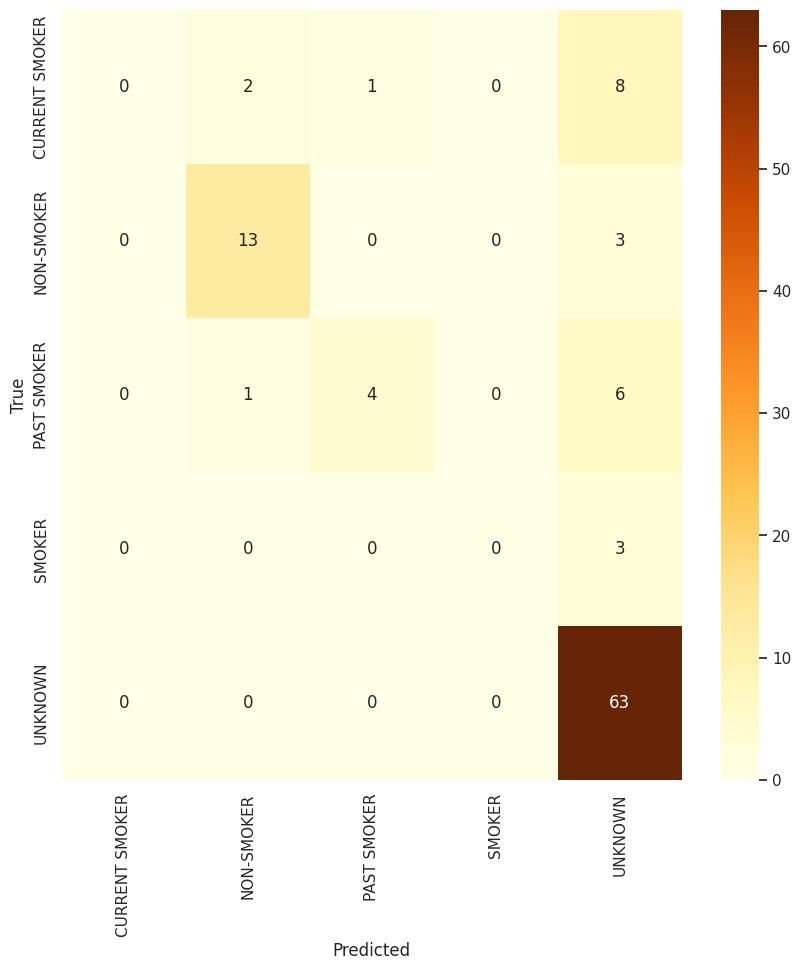

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Convert the list of tokens in SENTENCE_SMOKING to a single string
train_set['CLEAN_TOKENS_STR'] = train_set['CLEANED_TOKENS'].apply(lambda x: ' '.join(x))
test_set_labeled['CLEAN_TOKENS_STR'] = test_set_labeled['CLEANED_TOKENS'].apply(lambda x: ' '.join(x))

# Create a pipeline that first vectorizes the text using TF-IDF, then applies Naive Bayes
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), stop_words='english'), MultinomialNB())

# Fit the model with training data
model.fit(train_set['CLEAN_TOKENS_STR'], train_set['SMOKING'])

# Predict on the test set
y_pred = model.predict(test_set_labeled['CLEAN_TOKENS_STR'])

# Print the classification report to evaluate performance
print(classification_report(test_set_labeled['SMOKING'], y_pred))

conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix_nb)

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="YlOrBr", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()